In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
sys.path.append("../../utils")
from misc_utils import expected_loss
import os
from copy import deepcopy
from plotting_performance_vs_metric import get_closeness, get_log_closeness, get_spectrum
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array
from plotting_performance_vs_metric import get_nystrom_memory_with_model, get_rff_memory_with_model, get_cir_rff_memory_with_model
from plotting_performance_vs_metric import get_results_for_one_precision, plot_figure
import math
from plot_utils import get_colors

### plot performance v.s. approximation error

In [2]:
EPS = 1e-20

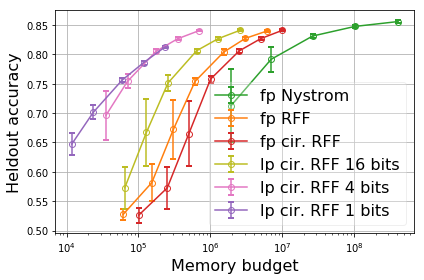

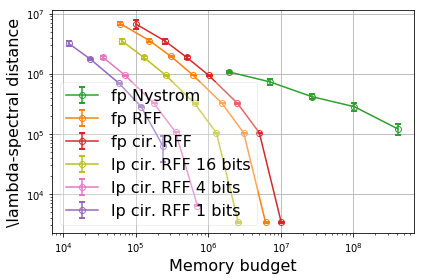

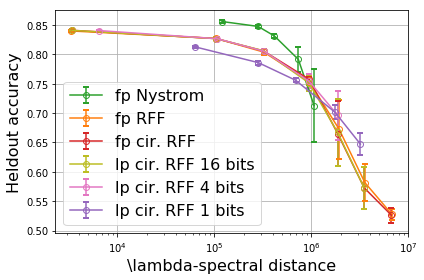

In [4]:
# n_rff_feat_dict = {64: [200, 500, 1000, 2000, 5000, 10000, 20000, 50000],
#            16: [500, 1000, 2000, 5000, 10000, 20000, 50000, ],
#            8: [1000, 2000, 5000, 10000, 20000, 50000],
#            4: [1000, 2000, 5000, 10000, 20000, 50000],
#            2: [1000, 2000, 5000, 10000, 20000, 50000],
#            1: [1000, 2000, 5000, 10000, 20000, 50000], }
n_rff_feat_dict = {64: [200, 500, 1000, 2000, 5000, 10000, 20000, ],
           16: [500, 1000, 2000, 5000, 10000, 20000 , ],
           8: [1000, 2000, 5000, 10000, 20000, ],
           4: [1000, 2000, 5000, 10000, 20000, ],
           2: [1000, 2000, 5000, 10000, 20000, ],
           1: [1000, 2000, 5000, 10000, 20000, ], }

m = 250
r = 54
# get results from cir rff runs
f_norm_dict_cir_rff = {}
l2_loss_list_cir_rff = {}
delta_list_cir_rff = {}
memory_list_cir_rff = {}
for nbit in [64, 16, 8, 4, 2, 1]:
    rff_mem_func = lambda n : get_cir_rff_memory_with_model(n, m, r, nbit, c=2)

    n_rff_feat = n_rff_feat_dict[nbit]
    general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
    general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
    general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_delta"
    folder_pattern = "covtype_type_cir_rff_l2_reg_1e-05_n_feat_unk_n_bit_" + str(nbit) + "_opt_sgd_lr_10_seed_unk"
#     folder_pattern = "census_type_cir_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(nbit) + "_seed_unk"
    f_norm_list, l2_loss_list, delta_list = \
        get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                      general_folder_performance, general_folder_delta,
                                      folder_pattern=folder_pattern, seeds=[1,2,3,4,5], min_best=False)
    memory_list = [rff_mem_func(x) for x in n_rff_feat]
    f_norm_dict_cir_rff[nbit] = deepcopy(f_norm_list)
    l2_loss_list_cir_rff[nbit] = deepcopy(l2_loss_list)
    delta_list_cir_rff[nbit] = deepcopy(delta_list)
    memory_list_cir_rff[nbit] = deepcopy(memory_list)
    
# get results from fp nystrom runs
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c=2)
n_nystrom_feat = [1250, 2500, 5000, 10000, 20000]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/closeness/classification_real_setting"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/closeness/classification_real_setting"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/symmetric_delta/classification_real_setting"
folder_pattern = "covtype_with_metric_type_nystrom_l2_reg_1e-05_n_fp_feat_unk_opt_sgd_lr_10_seed_unk"
f_norm_list_nystrom, l2_loss_list_nystrom, delta_list_nystrom = \
    get_results_for_one_precision(n_nystrom_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,4,5], min_best=False)
memory_list_nystrom = [nystrom_mem_func(x) for x in n_nystrom_feat]
    
# get results from basic rff runs
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c=2)
n_rff_feat = n_rff_feat_dict[64]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_delta"
# folder_pattern = "census_type_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(64) + "_seed_unk"
folder_pattern = "covtype_type_rff_l2_reg_1e-05_n_feat_unk_n_bit_" + str(64) + "_opt_sgd_lr_10_seed_unk"
f_norm_list_rff, l2_loss_list_rff, delta_list_rff = \
    get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,4,5], min_best=False)
memory_list_rff = [rff_mem_func(x) for x in n_rff_feat]        


# plot
plt.figure()
data_list = []
data_list.append(("fp Nystrom", memory_list_nystrom, l2_loss_list_nystrom) )
data_list.append(("fp RFF", memory_list_rff, l2_loss_list_rff) )
data_list.append(("fp cir. RFF", memory_list_cir_rff[64], l2_loss_list_cir_rff[64] ) )
for nbit in [16, 4, 1]:
    data_list.append(("lp cir. RFF " + str(nbit) + " bits", memory_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit] ) )
color_dict = get_colors()
plot_figure(data_list, color_dict)
plt.xscale("log")
plt.ylabel("Heldout accuracy", fontsize=16)
plt.xlabel("Memory budget", fontsize=16)
# plt.title("acc vs memory")
plt.legend(fontsize=16, framealpha=0.3)
plt.tight_layout()
plt.savefig("./figures/classification_acc_vs_mem.pdf")
# plt.ylim([None, 2e8])
plt.show()        

plt.figure()
data_list = []
data_list.append(("fp Nystrom", memory_list_nystrom, delta_list_nystrom) )
data_list.append(("fp RFF", memory_list_rff, delta_list_rff) )
data_list.append(("fp cir. RFF", memory_list_cir_rff[64], delta_list_cir_rff[64] ) )
for nbit in [16, 4, 1]:
    data_list.append(("lp cir. RFF " + str(nbit) + " bits", memory_list_cir_rff[nbit], delta_list_cir_rff[nbit] ) )
color_dict = get_colors()
plot_figure(data_list, color_dict)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("\lambda-spectral distance", fontsize=16)
plt.xlabel("Memory budget", fontsize=16)
# plt.title("delta vs memory")
plt.legend(fontsize=16, framealpha=0.3, loc="lower left")
plt.tight_layout()
plt.savefig("./figures/classification_delta_vs_mem.pdf")
# plt.ylim([None, 2e8])
plt.show()

# plt.figure()
# plt.plot(delta_list_rff, l2_loss_list_rff, "-o", label="fp rff ")  
# plt.plot(delta_list_nystrom, l2_loss_list_nystrom, "-o", label="fp Nystrom ")    
# for nbit in [64, 16, 4, 1]:
#     if nbit == 64:
#         plt.plot(delta_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit], "-o", label="fp cir rff ")
#     else:
#         plt.plot(delta_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit], "-o", label="lp cir rff " + str(nbit) )
# plt.grid()
# plt.yscale("log")
plt.figure()
data_list = []
data_list.append(("fp Nystrom", delta_list_nystrom, l2_loss_list_nystrom) )
data_list.append(("fp RFF", delta_list_rff, l2_loss_list_rff) )
data_list.append(("fp cir. RFF", delta_list_cir_rff[64], l2_loss_list_cir_rff[64] ) )
for nbit in [16, 4, 1]:
    data_list.append(("lp cir. RFF " + str(nbit) + " bits", delta_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit] ) )
color_dict = get_colors()
plot_figure(data_list, color_dict, ave_x=True)
plt.xscale("log")
plt.ylabel("Heldout accuracy", fontsize=16)
plt.xlabel("\lambda-spectral distance", fontsize=16)
# plt.title("acc vs delta")
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("./figures/classification_acc_vs_delta.pdf")
# plt.ylim([None, 2e8])
plt.show()


# # plt.figure()
# # for nbit in [64, 16, 8, 4, 2, 1]:
# #     plt.plot(n_rff_feat_dict[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
# # plt.plot(n_rff_feat_dict[64], l2_loss_list_rff, "-o", label="basic rff " + str(64) )    
# # plt.plot(n_nystrom_feat, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
# # plt.grid()
# # # plt.yscale("log")
# # plt.xscale("log")
# # plt.title("acc vs n feat")
# # plt.legend()
# # # plt.ylim([None, 2e8])
# # plt.show()

# # plt.figure()
# # for nbit in [64, 16, 8, 4, 2, 1]:
# #     plt.plot(n_rff_feat_dict[nbit], delta_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
# # plt.plot(n_rff_feat_dict[64], delta_list_rff, "-o", label="basic rff " + str(64) )    
# # plt.plot(n_nystrom_feat, delta_list_nystrom, "-o", label="Nystrom " + str(64) )    
# # plt.grid()
# # plt.yscale("log")
# # plt.xscale("log")
# # plt.title("delta vs n feat")
# # plt.legend()
# # # plt.ylim([None, 2e8])
# # plt.show()